In [72]:
import pandas as pd
import numpy as np
import os
import matplotlib as plt
import re
import math
from wordcloud import WordCloud
import pyLDAvis
import seaborn

from pprint import pprint

#SKYLEARN
from sklearn.datasets import fetch_20newsgroups 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#NTLK
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('words', quiet=True)
from nltk.tokenize import regexp_tokenize, wordpunct_tokenize, RegexpTokenizer
from nltk.tokenize import sent_tokenize, PunktSentenceTokenizer, WhitespaceTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn 
from nltk.corpus import stopwords

#CORPORA
import gensim
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

# Visualization
import pyLDAvis
import pyLDAvis.gensim  
from sklearn.manifold import TSNE

# Warnings
import warnings
warnings.filterwarnings("ignore")

print('All libraries imported successfully')

All libraries imported successfully


In [32]:
def preprocess( data ):
    newdata = []
    for idx, x in enumerate(data): #x -- document in data 
        newdoc = ""
        stop_words = stopwords.words('english')
        words = set(nltk.corpus.words.words())

        for token in sent_tokenize(x): #token -- sentence in doc
            seperator = " " 
            token = re.sub('[^A-Za-z0-9]+', ' ', token) #remove special characters
            token = re.sub(r'\d+', '', token) #remove numbers
            token = re.sub(r'\b\w{1,2}\b', '', token) #remove words with <= 2 characters
            #         if w.lower() in words or not w.isalpha())
            whitespace_token = WhitespaceTokenizer().tokenize( token )
            wo_stopwords_token = [x for x in whitespace_token
                                  if not x in stop_words]
            newdoc += seperator.join( (wo_stopwords_token) ).lower()
            newdoc += " " 
            
        # Word Tokens for Each Document
        word_tokens = RegexpTokenizer('\s+', gaps=True).tokenize(newdoc)
        data[idx] = word_tokens 
        newdata.append( data[idx] )
        
    return newdata

In [33]:
# Import and clean data
chosen_category = 'sci.space'
print("Loading 20 newsgroups dataset for category " + chosen_category)
newsgroups_train = fetch_20newsgroups(subset='train', categories=[chosen_category],
                                      remove=('headers', 'footers', 'quotes'))
newdata = preprocess(newsgroups_train.data)
pprint("Data Cleaned")

Loading 20 newsgroups dataset for category sci.space
'Data Cleaned'


In [34]:
# Actual Bag of Words and LDA
dictionary = gensim.corpora.Dictionary(newdata)
bow_corpus = [dictionary.doc2bow(doc) for doc in newdata]
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = 5, id2word = dictionary, passes = 10, workers = 2)
pprint(lda_model.print_topics())

[(0,
  '0.017*"the" + 0.006*"space" + 0.005*"one" + 0.004*"first" + 0.004*"mission" '
  '+ 0.004*"would" + 0.004*"orbit" + 0.003*"data" + 0.003*"moon" + '
  '0.003*"also"'),
 (1,
  '0.007*"space" + 0.005*"the" + 0.005*"earth" + 0.004*"nasa" + '
  '0.004*"station" + 0.004*"van" + 0.003*"would" + 0.003*"new" + 0.003*"also" '
  '+ 0.003*"billion"'),
 (2,
  '0.024*"space" + 0.010*"the" + 0.009*"nasa" + 0.006*"launch" + 0.004*"data" '
  '+ 0.004*"edu" + 0.004*"satellite" + 0.004*"shuttle" + 0.003*"program" + '
  '0.003*"also"'),
 (3,
  '0.010*"the" + 0.009*"would" + 0.006*"space" + 0.006*"like" + '
  '0.004*"software" + 0.003*"could" + 0.003*"one" + 0.003*"this" + '
  '0.003*"time" + 0.003*"much"'),
 (4,
  '0.008*"space" + 0.008*"the" + 0.007*"would" + 0.005*"like" + 0.004*"get" + '
  '0.004*"think" + 0.004*"one" + 0.003*"time" + 0.003*"people" + 0.003*"moon"')]


In [13]:
# LDA Visualization
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

In [21]:
# TSNE Bokeh
refactored_df = np.array([[y for (x,y) in lda_model[bow_corpus[i]]] for i in range(len(bow_corpus))])
tsne = TSNE(perplexity=30, early_exaggeration=120)

In [35]:
def explore_topic(lda_model, topic_number, topn, output=True):
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(5):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(lda_model,topic_number=i, topn=10, output=True )
#     print tmp[:5]
    topic_summaries += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

the                  0.017
space                0.006
one                  0.005
first                0.004
mission              0.004
would                0.004
orbit                0.004
data                 0.003
moon                 0.003
also                 0.003
Topic 1 |---------------------

space                0.007
the                  0.005
earth                0.005
nasa                 0.004
station              0.004
van                  0.004
would                0.003
new                  0.003
also                 0.003
billion              0.003
Topic 2 |---------------------

space                0.024
the                  0.010
nasa                 0.009
launch               0.006
data                 0.004
edu                  0.004
satellite            0.004
shuttle              0.004
program              0.003
also                 0.003
Topic 3 |---------------------

the                  0.010
wou

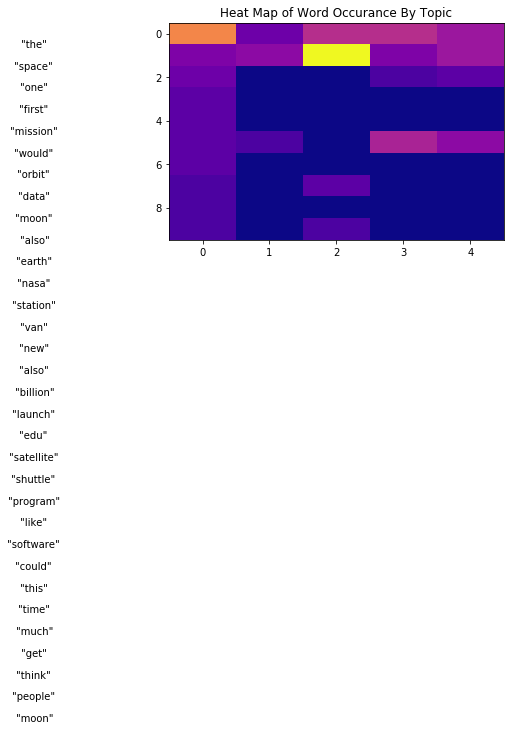

In [127]:
topicWordProbMat = lda_model.print_topics(5)
columns = ['Topic 1','Topic 2','Topic 3','Topic 4','Topic 5']
df = pd.DataFrame(columns = columns)
occurance = np.zeros(shape=(40,5)) # I have zero idea why this number needs to be 40

for x in range (10):
  temp_data = pd.DataFrame({columns[0]:"", columns[1]:"", columns[2]:"", columns[3]:"", columns[4]:"", },index=[0])
  df = df.append(temp_data,ignore_index = True)  
    
for line in topicWordProbMat:
    tp, w = line
    probs=w.split("+")
    y=0
    for pr in probs:     
        a=pr.split("*")
        df.iloc[y,tp] = a[1]
        if a[1] in DC:
           occurance[DC[a[1]]][tp]=a[0]
        else:
           occurance[last_number][tp]=a[0]
           DC[a[1]]=last_number
           last_number=last_number+1
        y=y+1

occurance = np.resize(occurance, (len(DC.keys()), occurance.shape[1]))

for val, key in enumerate(DC.keys()):
        plt.text(-2.5, val + 0.5, key,
                 horizontalalignment='center',
                 verticalalignment='center'
                 )

plt.imshow(occurance[0:10], cmap='plasma', interpolation='nearest', aspect='auto')
plt.title('Heat Map of Word Occurance By Topic')
plt.savefig('Heat Map.png')
plt.show()